# **Getting started with sbi**

In [15]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import infer

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Problem: We want to estimate the gravitational acceleration of a hypothetical planet with projectile motion


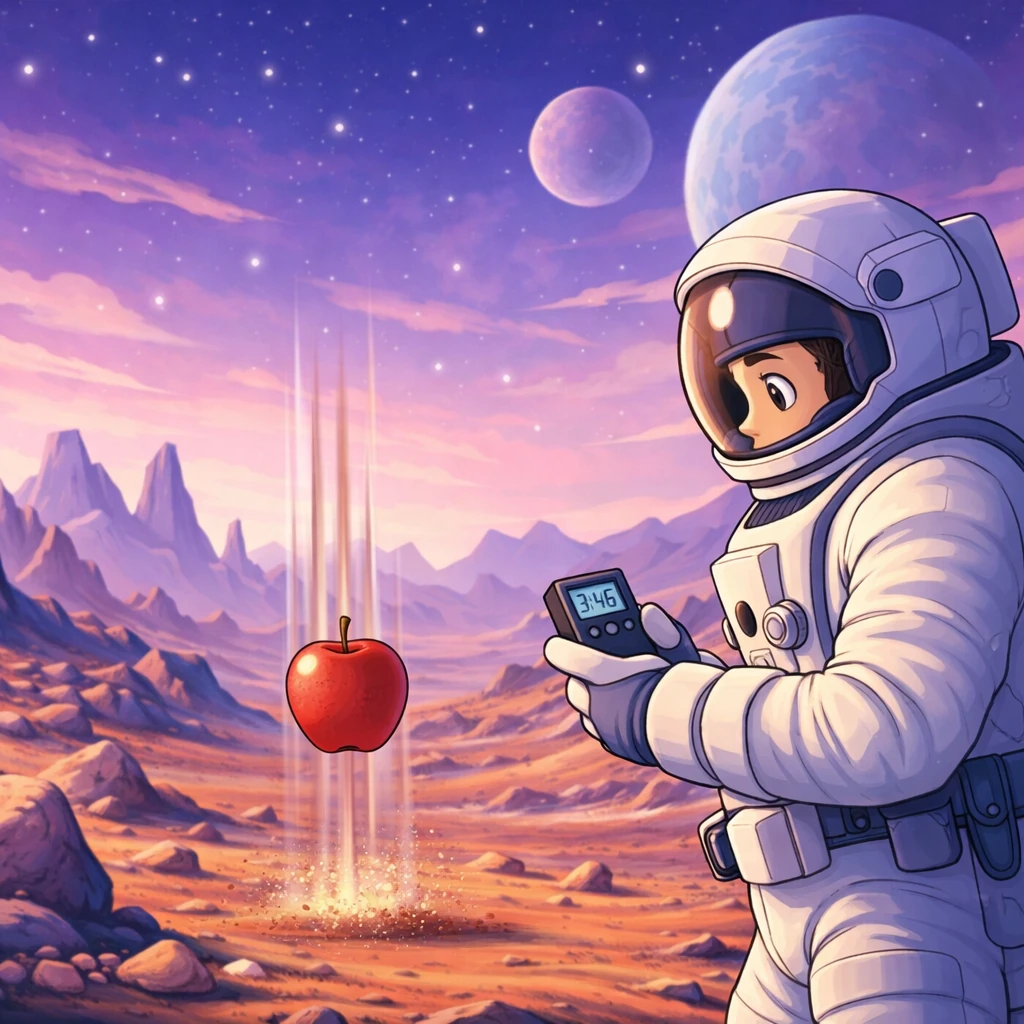

Text(0.5, 1.0, 'Observation')

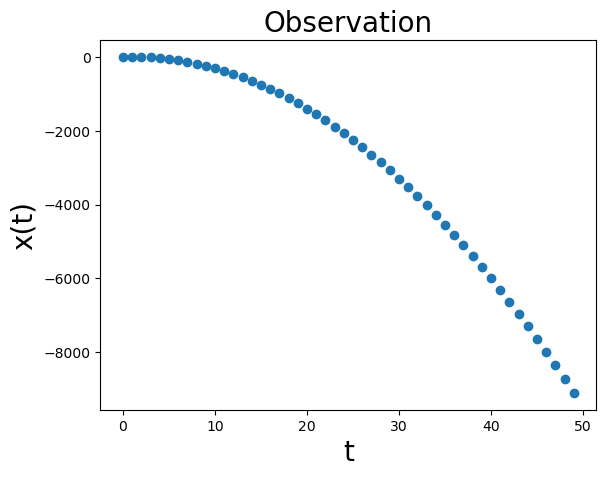

In [4]:
t = torch.arange(0,50)
x_t = -0.5*8*t**2 + 10*t 
plt.scatter(t, x_t)
plt.xlabel('t', fontsize=20)
plt.ylabel('x(t)', fontsize=20)
plt.title('Observation', fontsize=20)

### To perform simulation-based inference, several key components must be specified:

* First, an observation model is chosen; assuming **Newtonian mechanics**, the motion of a freely falling object is described by:
  $$x(t) = -\frac{1}{2} g \,t^2 + v_0t$$
* We first define a prior distribution over the parameters of interest, here the gravitational acceleration $g$ and the initial velocity $v_0$:
  $$g \in [0,10] \; \; \; and \; \; \; v_0 \in [0,20] $$ 



* A simulator then takes the sampled parameters and generates synthetic observations.

* By training a model on these simulations, the gravitational acceleration and the initial velocity of the falling object can be inferred from observational data.

In [5]:
num_dim = 2
prior = utils.BoxUniform(low=torch.tensor([0,0]), high= torch.tensor([10,20]))
def simulator(parameter_set):
    t = torch.arange(0,50)
    return  -0.5*parameter_set[0]*t**2 + parameter_set[1]*t+torch.randn(t.shape) * 0.1

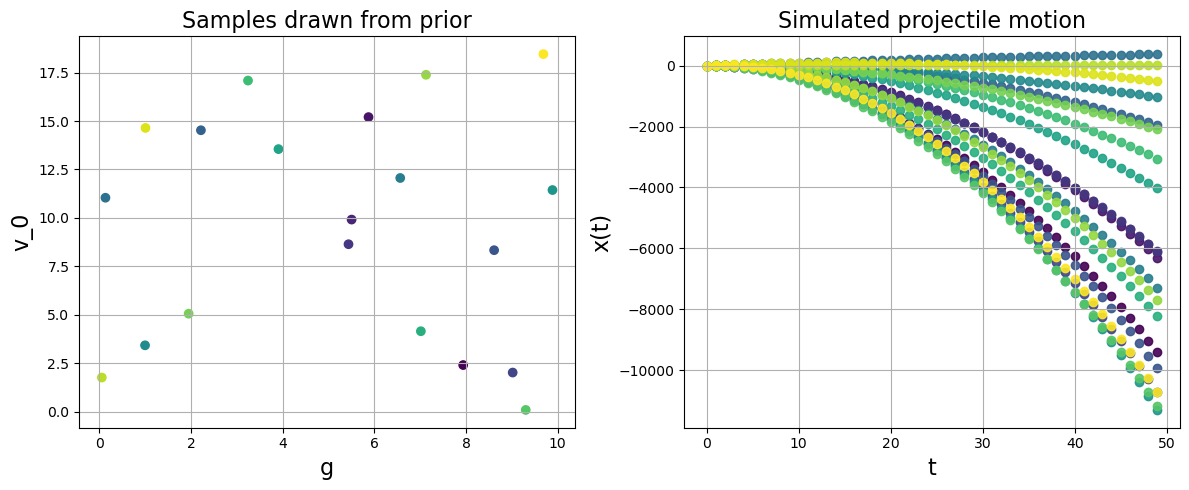

In [6]:
# Sample parameters from prior
num_samples = 20
prior_samples = prior.sample((num_samples,))

# Generate simulation outputs
sim_outputs = [simulator(s) for s in prior_samples]

colors = cm.viridis(torch.linspace(0, 1, num_samples))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(prior_samples[:, 0], prior_samples[:, 1], c=colors)
axes[0].set_xlabel("g",fontsize=16)
axes[0].set_ylabel('v_0',fontsize=16)
axes[0].set_title("Samples drawn from prior",fontsize=16)
axes[0].grid(True)
t = torch.arange(0, 50.0)
for x, c in zip(sim_outputs, colors):
    axes[1].scatter(t,x, color=c, alpha=0.9)
axes[1].set_xlabel("t",fontsize=16)
axes[1].set_ylabel("x(t)",fontsize=16)
axes[1].set_title("Simulated projectile motion",fontsize=16)
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [7]:
# Other methods are "SNLE" or "SNRE".
posterior = infer(simulator, prior, method="SNPE", num_simulations=3000)

100%|██████████| 3000/3000 [00:00<00:00, 59395.38it/s]


 Neural network successfully converged after 175 epochs.

In [8]:
# observation
t = torch.arange(0,50)
observation = -0.5*5*t**2 + 8*t

In [9]:
samples = posterior.sample((10000,), x=observation)

100%|██████████| 10000/10000 [00:00<00:00, 499666.91it/s]


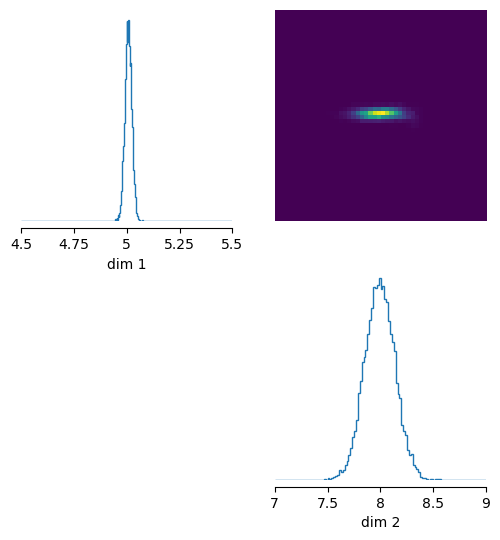

In [10]:
_ = analysis.pairplot(samples, limits=[[4.5, 5.5], [7, 9]], figsize=(6, 6))

## **Amortized posterior inference**

In this example, we will demonstrate how sbi can infer an amortized posterior for Projectile motion model

In [17]:
t = torch.arange(0,50)
# planet id : 01
x_ob_1 = -0.5*6*t**2 + 7*t

# planet id : 02
x_ob_2 = -0.5*3*t**2 + 15*t

In [12]:
samples_1 = posterior.sample((10000,), x=x_ob_1)

100%|██████████| 10000/10000 [00:00<00:00, 123694.40it/s]


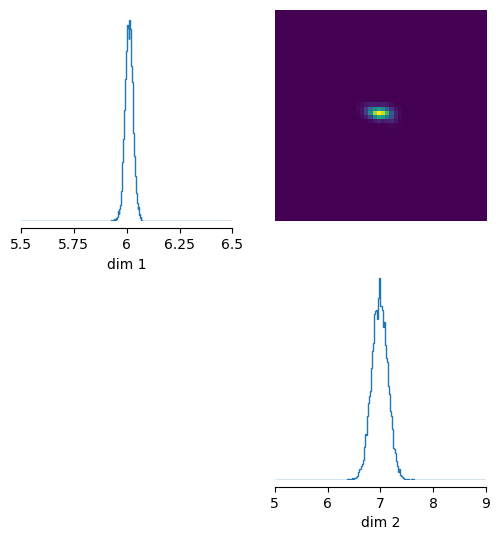

In [16]:
_ = analysis.pairplot(samples_1, limits=[[5.5, 6.5], [5, 9]], figsize=(6, 6))

In [20]:
samples_2 = posterior.sample((10000,), x=x_ob_2)

100%|██████████| 10000/10000 [00:00<00:00, 538007.18it/s]


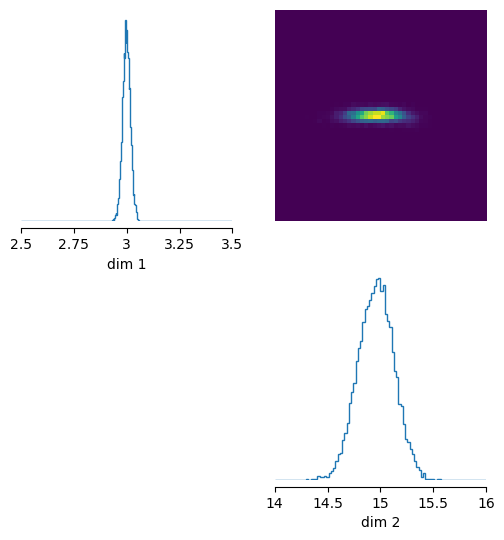

In [23]:
_ = analysis.pairplot(samples_2, limits=[[2.5, 3.5], [14, 16]], figsize=(6, 6))

## **Corresponding Getdist plots**


See:
https://getdist.readthedocs.io/en/latest

In [ ]:
# How to install 
!pip install getdist -q

In [43]:
# Show plots inline, and load main getdist plot module and samples class
# %matplotlib inline
import getdist
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np

# print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

In [39]:
samples_1

tensor([[5.9756, 7.2048],
        [5.9874, 7.0554],
        [6.0160, 6.7913],
        ...,
        [6.0021, 6.9837],
        [6.0300, 7.1272],
        [5.9970, 6.9320]])

In [40]:
samples_1.shape

torch.Size([10000, 2])

In [41]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
ndim = 2
names = ["x%s"%i for i in range(ndim)]
labels =  ['g','V_0']
samples_plot_1 = MCSamples(samples=np.array(samples_1),names = names, labels = labels,  label='label=Planet id:01')
samples_plot_2 = MCSamples(samples=np.array(samples_2),names = names, labels = labels, label='label=Planet id:02')

Removed no burn in
Removed no burn in


/tmp/ipykernel_21582/1043968105.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples_plot_1 = MCSamples(samples=np.array(samples_1),names = names, labels = labels,  label='label=Planet id:01')
/tmp/ipykernel_21582/1043968105.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples_plot_2 = MCSamples(samples=np.array(samples_2),names = names, labels = labels, label='label=Planet id:02')


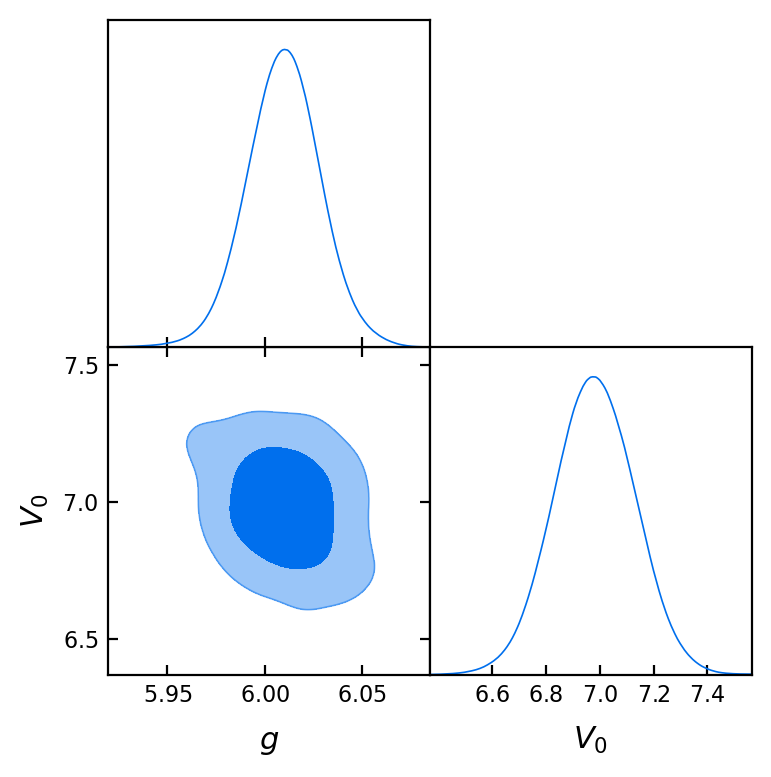

In [42]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_plot_1], filled=True)

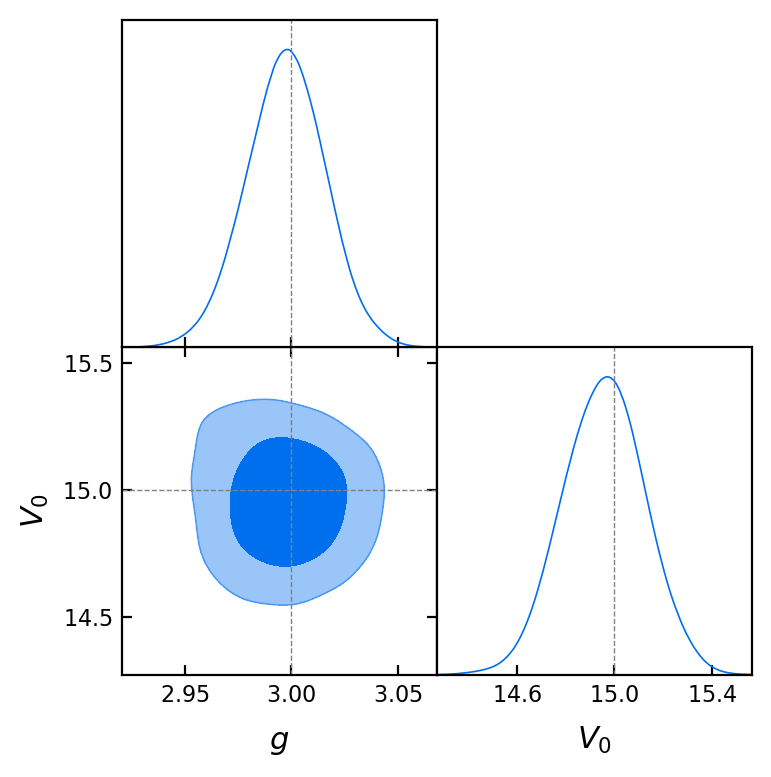

In [51]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_plot_2], filled=True,
                markers={'x0': 3, 
                        'x1': 15})
# g.export("fig_1.pdf")  # Saves in current working directory

# **Flexible interface**


In the previous examples, we have demonstrated how sbi can be used to run simulation-based inference with just a single line of code.

In addition to this simple interface, sbi also provides a flexible interface which provides several additional features implemented in sbi.

**Features**


The flexible interface offers the following features (and many more):

    

*   performing sequential posterior estimation by focusing on a  particular observation over multiple rounds. This can decrease the number of simulations one has to run, but the inference procedure is no longer amortized
*   specify your own density estimator, or change hyperparameters of existing ones
*    use an embedding_net to learn summary features from high-dimensional simulation outputs (field-level inferernce)
*   provide presimulated data



## **Flexible interface: starting point**


In [17]:
import torch
from sbi.inference import SNPE, NPE, simulate_for_sbi
from sbi.neural_nets import posterior_nn
from sbi import utils as utils

**In the flexible interface, you have to ensure that your simulator and prior adhere the requirements of sbi. You can do so with the simulate_for_sbi() function**.

In [184]:
num_dim = 2
prior = utils.BoxUniform(
    low=torch.tensor([0., 0.]),
    high=torch.tensor([10., 20.])
)

def Projectile_motion(theta):
    """
    theta: shape (N, 2)
    returns: shape (N, T)
    """
    t = torch.arange(0, 50).float()          # (T,)
    t = t.unsqueeze(0)                       # (1, T)

    a = theta[:, 0].unsqueeze(1)             # (N, 1)
    v0 = theta[:, 1].unsqueeze(1)            # (N, 1)

    x = -0.5 * a * t**2 + v0 * t              # (N, T)
    return x


In [185]:
theta, x = simulate_for_sbi(
    simulator=Projectile_motion,
    proposal=prior,
    num_simulations=3000
)

print(theta.shape)  # (20, 2)
print(x.shape)      # (20, 50)


100%|██████████| 3000/3000 [00:00<00:00, 54677.41it/s]

torch.Size([3000, 2])
torch.Size([3000, 50])


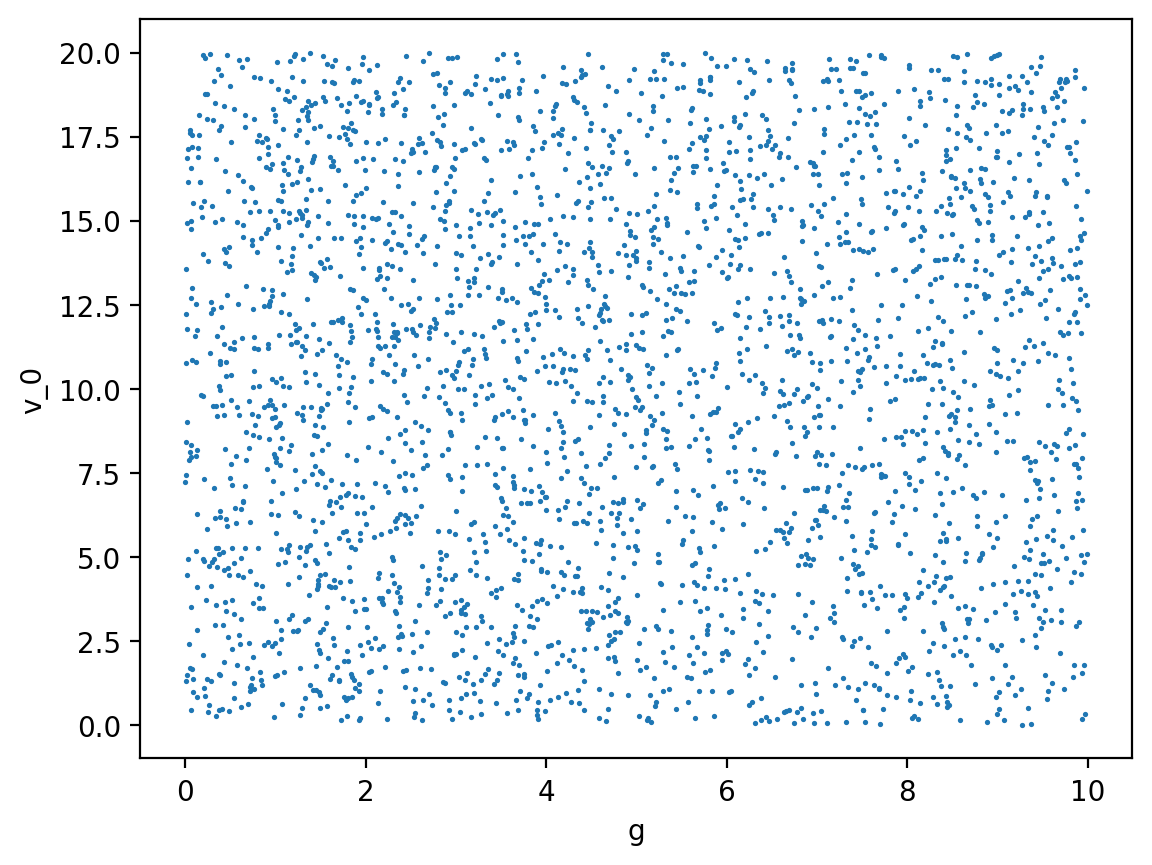

In [188]:
plt.scatter(theta[:,0], theta[:,1],s=0.8)
plt.ylabel('v_0')
plt.xlabel('g')
plt.show()

In [195]:
inference = NPE(prior=prior)

In [196]:
inference

In [197]:
density_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 224 epochs.

In [198]:
density_estimator

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
            (context_layer): Linear(in_features=50, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=50, out_features=4, bias=True)
          )
        )
        (2): RandomPermutation()
        (3): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
            (context_layer): Linear(in_featur

In [199]:
posterior = inference.build_posterior(density_estimator)

In [200]:
t = torch.arange(0,50)
# planet id : 01
x_obs = -0.5*6*t**2 + 7*t
posterior_samples = posterior.sample((10000,), x=x_obs)

100%|██████████| 10000/10000 [00:00<00:00, 177208.14it/s]


In [201]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
ndim = 2
names = ["x%s"%i for i in range(ndim)]
labels =  ['g','V_0']
samples_plot = MCSamples(samples=np.array(posterior_samples),names = names, labels = labels,  label='label=Planet id:01')

Removed no burn in


/tmp/ipykernel_21582/252636105.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples_plot = MCSamples(samples=np.array(posterior_samples),names = names, labels = labels,  label='label=Planet id:01')


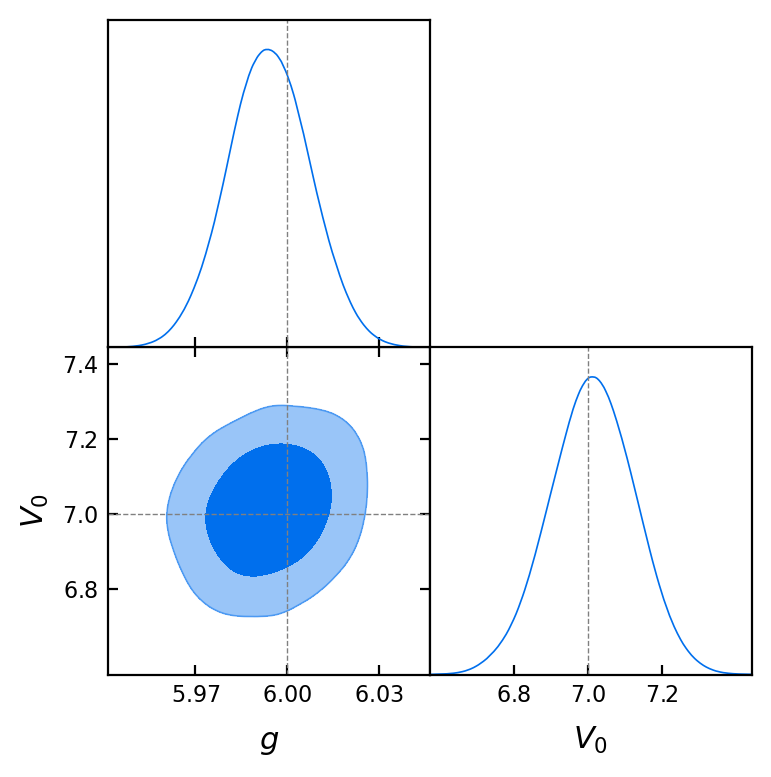

In [202]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_plot], filled=True,
                markers={'x0': 6, 
                        'x1': 7})
# g.export("fig_1.pdf")  # Saves in current working directory

## **Flexible interface: Sequential inference**

In the previous examples, we have inferred the posterior using **single-round inference**. In **single-round inference**, we draw parameters from the prior, simulate the corresponding data, and then train a neural network to obtain the posterior. However, if one is interested in only one particular observation x_o sampling from the prior can be inefficient in the number of simulations because one is effectively learning a posterior estimate for all observations in the prior space. In this example, we show how one can alleviate this issue by performing **Sequential inference with sbi**.

**Sequential inference** also starts by drawing parameters from the prior, simulating them, and training a neural network to estimate the posterior distribution. Afterwards, however, it continues inference in multiple rounds, focusing on a particular observation x_o. In each new round of inference, it draws samples from the obtained posterior distribution conditioned at x_o (instead of from the prior), simulates these, and trains the network again. This process can be repeated arbitrarily often to get increasingly good approximations to the true posterior distribution at x_o

Running **Sequential inference** can be more efficient in the number of simulations, but it will lead to the posterior no longer being amortized (i.e. it will be accurate only for a specific observation x_o, not for any x).

In [209]:
num_dim = 2
prior = utils.BoxUniform(
    low=torch.tensor([0., 0.]),
    high=torch.tensor([10., 20.])
)

def Projectile_motion(theta):
    """
    theta: shape (N, 2)
    returns: shape (N, T)
    """
    t = torch.arange(0, 50).float()          # (T,)
    t = t.unsqueeze(0)                       # (1, T)

    a = theta[:, 0].unsqueeze(1)             # (N, 1)
    v0 = theta[:, 1].unsqueeze(1)            # (N, 1)

    x = -0.5 * a * t**2 + v0 * t              # (N, T)
    return x


In [210]:
inference = SNPE(prior=prior)

In [211]:
num_rounds = 4
t = torch.arange(0,50)
x_o = -0.5*5*t**2 + 8*t
posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator=Projectile_motion, proposal=prior, num_simulations=1000)  
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

100%|██████████| 1000/1000 [00:00<00:00, 38770.45it/s]


 Neural network successfully converged after 365 epochs.

100%|██████████| 1000/1000 [00:00<00:00, 96569.52it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 66 epochs.

100%|██████████| 1000/1000 [00:00<00:00, 95876.38it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

100%|██████████| 1000/1000 [00:00<00:00, 92462.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

In [212]:
posterior_samples = posterior.sample((10000,), x=x_o)

100%|██████████| 10000/10000 [00:00<00:00, 214765.41it/s]


In [213]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
ndim = 2
names = ["x%s"%i for i in range(ndim)]
labels =  ['g','V_0']
samples_plot = MCSamples(samples=np.array(posterior_samples),names = names, labels = labels,  label='label=Planet id:01')

Removed no burn in


/tmp/ipykernel_21582/252636105.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples_plot = MCSamples(samples=np.array(posterior_samples),names = names, labels = labels,  label='label=Planet id:01')


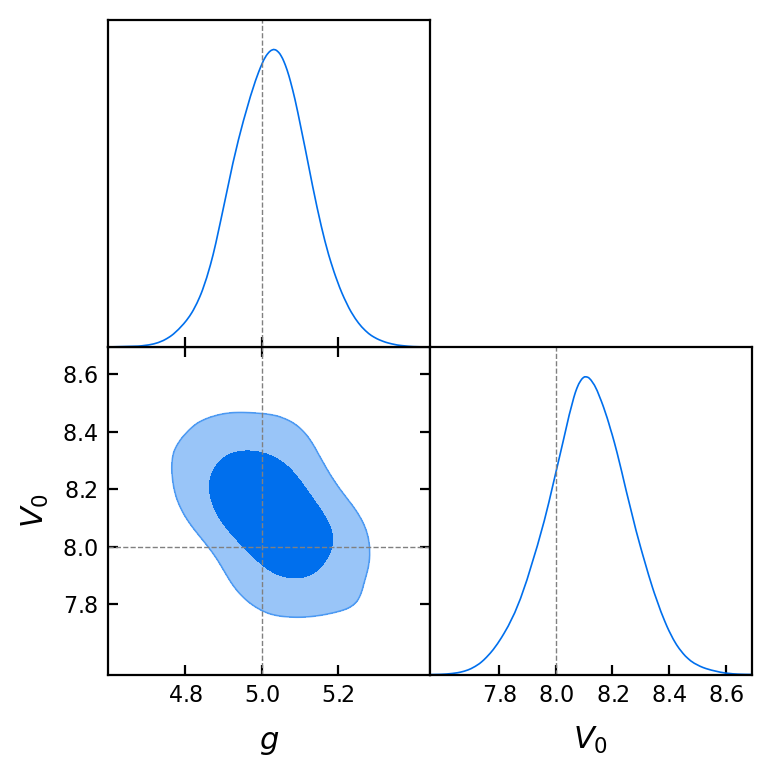

In [215]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_plot], filled=True,
                markers={'x0': 5, 
                        'x1': 8})
# g.export("fig_1.pdf")  # Saves in current working directory

## **Flexible interface:  Customizing the Density Estimator**

sbi allows to specify a custom density estimator for each of the implemented methods.

### Changing the type of density estimator

One option is to use one of set of preconfigured density estimators by passing a string in the density_estimator keyword argument to the inference object (SNPE or SNLE), e.g., “maf” to use a **Masked Autoregressive Flow**, of “nsf” to use a **Neural Spline Flow** with default hyperparameters.

In [221]:
inference = NPE(prior=prior, density_estimator="maf")

In [222]:
theta, x = simulate_for_sbi(
    simulator=Projectile_motion,
    proposal=prior,
    num_simulations=3000
)

100%|██████████| 3000/3000 [00:00<00:00, 62118.20it/s]


In [223]:
Density_Estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 105 epochs.

In [225]:
Density_Estimator;

In [227]:
posterior = inference.build_posterior(Density_Estimator)

### Changing hyperparameters of Density Estimators

Alternatively, you can use a set of utils functions to configure a density estimator yourself, e.g., use a MAF with hyperparameters chosen for your problem at hand.

Here, because we want to use SN*P*E, we specifiy a neural network targeting the posterior (using the utils function posterior_nn). In this example, we will create a neural spline flow ('nsf') with 60 hidden units and 3 transform layers:

In [20]:
from sbi.neural_nets import posterior_nn

In [229]:
density_estimator_build_fun = posterior_nn(
    model="nsf", hidden_features=60, num_transforms=3
)
inference = NPE(prior=prior, density_estimator=density_estimator_build_fun)

...

In [230]:
# posterior_nn(
#             model=config.get("model", "nsf"),
#             hidden_features=config.get("hidden_features", 50),
#             num_transforms=config.get("num_transforms", 2),
#             num_bins=config.get("num_bins", 2),
#             batch_norm=config.get("batch_norm", True),
#             tail_bound=config.get("tail_bound", 3),
#             dropout_probability=config.get("dropout_probability", 0.0)
#         )

## **Flexible interface:  Learning summary statistics with a neural net (Field-Level Inference)**

When doing simulation-based inference, it is very important to use well-chosen summary statistics for describing the data generated by the simulator. Usually, these statistics take into account domain knowledge.

However, in other cases, it might be of interest to actually learn from the data which summary statistics to use, e.g., because the raw data is highly complex and domain knowledge is not available or not applicable.

sbi offers functionality to learn summary statistics from (potentially high-dimensional) simulation outputs with a neural network. In sbi, this neural network is referred to as **embedding_net**. If an embedding_net is specified, the simulation outputs are passed through the embedding_net, whose outputs are then passed to the neural density estimator. The parameters of the embedding_net are learned together with the parameters of the neural density estimator. sbi provides pre-configured embedding networks (MLP, CNN, premutation-invariant networks) or allows to pass custom-written embedding networks.

NB: only SNPE and SNRE methods can use an embedding_net to learn summary statistics from simulation outputs. SNLE does not offer this functionality since the simulation outputs x are the outputs of the neural density estimator.

In the example that follows, we illustrate a situation where the data points generated by the simulator model are high-dimensional (32 by 32 images) and we use a convolutional neural network as summary statistics extractor.

In [ ]:
# !pip install pyfftw -q
# !pip install powerbox -q

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import powerbox as pbox
from powerbox import get_power

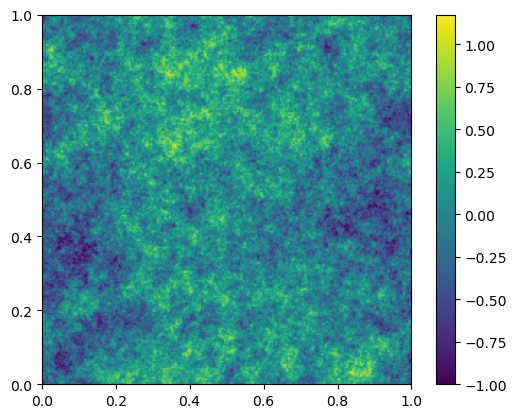

In [2]:
pb = pbox.PowerBox(
    N=256,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1000.0,        # Size of the box (sets the units of k in pk)
    seed = 30,                 # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


plt.imshow(pb.delta_x(),extent=(0,1,0,1))
plt.colorbar()
plt.show()

In [3]:
p_k_field, bins_field = get_power(pb.delta_x(), pb.boxlength)

/home/jovyan/envs/sbi_env_2/lib/python3.11/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)


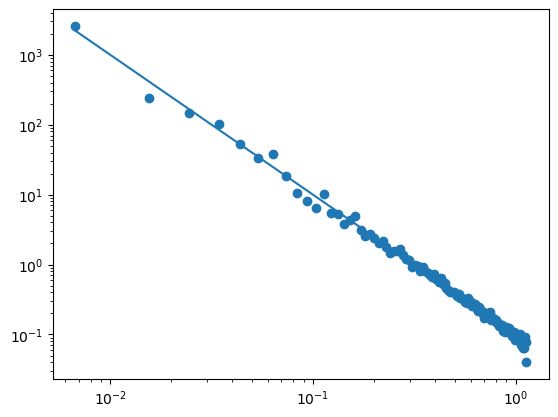

In [8]:
plt.plot(bins_field, 0.1*bins_field**-2.)
plt.scatter(bins_field, p_k_field)
plt.xscale('log')
plt.yscale('log')

In [34]:
def simulator_model(theta):
    """
    theta: torch.Tensor with shape (N, 2)
           theta[:, 0] = amplitude
           theta[:, 1] = spectral index
    returns:
        x: torch.Tensor with shape (N, 64, 64)
    """

    theta = theta.detach().cpu().numpy()   # (N, 2)
    simulations = []

    for i in range(theta.shape[0]):
        A = theta[i, 0]
        n = theta[i, 1]

        pb = pbox.PowerBox(
            N=64,
            dim=2,
            pk=lambda k, A=A, n=n: A * k**n,
            boxlength=1000.0,
            ensure_physical=True
        )

        delta_x = pb.delta_x()  # (64, 64)
        simulations.append(delta_x)

    x = torch.tensor(
        np.stack(simulations, axis=0),
        dtype=torch.float32
    )  # (N, 64, 64)

    return x


In [35]:
# set prior distribution for the parameters
prior = utils.BoxUniform(
    low=torch.tensor([1, -3]), high=torch.tensor([3.0, -1.0]))

# make a SBI-wrapper on the simulator object for compatibility
# simulator_wrapper, prior = prepare_for_sbi(simulator_model, prior)

In [36]:
from sbi.neural_nets.embedding_nets import FCEmbedding, CNNEmbedding, PermutationInvariantEmbedding

embedding_net = CNNEmbedding(input_shape=(64, 64))

In [37]:
# instantiate the neural density estimator
neural_posterior = posterior_nn(
    model="maf", embedding_net=embedding_net, 
    hidden_features=10, num_transforms=2)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [38]:
theta, x = simulate_for_sbi(simulator_model, prior, num_simulations=3000)

100%|██████████| 3000/3000 [00:01<00:00, 2320.31it/s]


In [39]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 171 epochs.

In [41]:
# true parameters (batch size = 1)
true_parameter = torch.tensor([[2.0, -1.5]])  # shape: (1, 2)

# generate observed data
x_observed = simulator_model(true_parameter)  # shape: (1, 64, 64)

# posterior sampling
samples = posterior.set_default_x(x_observed).sample((50_000,))


51359it [00:00, 1091998.45it/s]          


In [44]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
ndim = 2
names = ["x%s"%i for i in range(ndim)]
labels =  ['A','n']
samples_plot = MCSamples(samples=np.array(samples),names = names, labels = labels,  label='label=Planet id:01')

Removed no burn in


/tmp/ipykernel_25127/4032353082.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples_plot = MCSamples(samples=np.array(samples),names = names, labels = labels,  label='label=Planet id:01')


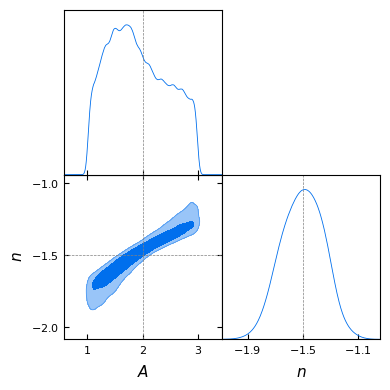

In [45]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_plot], filled=True,
                markers={'x0': 2, 
                        'x1': -1.5})
# g.export("fig_1.pdf")  # Saves in current working directory